In [1]:
%cd ..

/Users/juansegundohevia/Documents/repos/ConceptGuidedColorization


In [3]:
import os 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from palette_model.PaletteGeneration import PaletteDecoder
from munch import Munch
import torch
import open_clip

/Users/juansegundohevia/anaconda3/envs/elec542project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import warnings 
from skimage.color import lab2rgb, rgb2lab

def lab2rgb_1d(in_lab, clip=True):
    warnings.filterwarnings("ignore")
    tmp_rgb = lab2rgb(in_lab[np.newaxis, np.newaxis, :], illuminant='D50').flatten()
    if clip:
        tmp_rgb = np.clip(tmp_rgb, 0, 1)
    return tmp_rgb

In [6]:
# model config

CONFIG = {
    "learning_rate": 1e-4,
    "batch_size": 256,
    "num_epochs": 5000,
    "max_len": 10,
    "embedding_dim": 512,
    "num_blocks": 4,
    "reduce_factor": 2,
    "save_every": 250,
    "train_embeddings": "data/clip_embs/train_palette_prompts.pt",
    "train_trg_path": "data/hexcolor_vf/train_palettes_rgb.pkl",
    "test_embeddings": "data/clip_embs/test_palette_prompts.pt",
    "test_trg_path": "data/hexcolor_vf/train_palettes_rgb.pkl",
    "resume": False,
    "save_dir": "weights/PaletteEncoder"
}

config = Munch(CONFIG)


In [7]:
# load checkpoints
PATH = "20241101-105348"
ckps_all = os.listdir(os.path.join(config.save_dir, PATH))
# get max epoch ckp
ckps = [ckp for ckp in ckps_all if "epoch" in ckp]
max_epoch = max([int(ckp.split(".")[0].split("_")[2]) for ckp in ckps])
ckp_path = os.path.join(config.save_dir, PATH, f"model_epoch_{max_epoch}.pth")

In [8]:
ckp_path

'weights/PaletteEncoder/20241101-105348/model_epoch_4750.pth'

In [9]:
dec = PaletteDecoder(n_blocks=config.num_blocks,
                       in_channels=config.embedding_dim,
                       num_colors=5,
                       reduce_factor=config.reduce_factor)

dec.load_state_dict(torch.load(ckp_path))
dec.eval()
dec.training

/var/folders/2c/s1dc7gqn0jz4dls2kprq822m0000gn/T/ipykernel_74715/2621736207.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dec.load_state_dict(torch.load(ckp_path))


False

In [10]:
# load CLIP tokenizer and model
device = "mps" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "ViT-B-32"
tokenizer = open_clip.get_tokenizer(MODEL_NAME)
model, _, _ = open_clip.create_model_and_transforms(MODEL_NAME, pretrained='laion2b_s34b_b79k')
model.eval()
model.training

False

embedding size:  torch.Size([1, 512])
result output size: torch.Size([1, 5, 3])


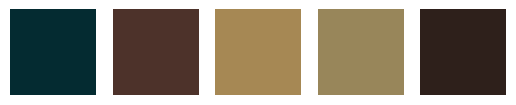

In [26]:
# make inference
text = "more dramatic"
tokens = tokenizer(text)
emb = model.encode_text(tokens.to(device))
print("embedding size: ", emb.size())

# Repeat the input tensor along the channel dimension to have 3 channels
res = dec(emb.squeeze(0))
print("result output size:", res.size())


# plot palette using 5 color patches
colors = res.detach().cpu().numpy().reshape(-1, 3)

rgb = lab2rgb_1d(colors)
rgb = rgb.reshape(-1, 3)

for i, color in enumerate(colors):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.ones((100, 100, 3)) * color)
    plt.axis("off")
